---
cdt: 2024-09-04T14:00:00
title: "Meaning of Factors, Scaling and Reconstruction"
description: "A demonstration of the meaning of the factors of the PARAFAC2 model from the point of view of a HPLC-MS decomposition and how to combine them to compare the pure components with the input data at scale."
status: closed
conclusion: "Using the Zhang et al. GC-MS peak data, observation of the following features was made: The scaled elution profiles, the pure elution profiles, A as a function of K for each component and C as a function of J. A reconstruction routine was developed and visualisations the results of reconstruction. The reconstruction routine/viz should be integrated into a pipeline."
project: parafac2
---

To scale the individual compound profiles for a given sample $k$ and wavelength $j$, multiply the elution profile by the corresponding concentration loading ($kth$ row of $A$) and a spectral loading ($j$th row of $C$), as below:

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/jonathan/Library/Caches/pypoetry/virtualenvs/pca-analysis-6KQS4gUX-py3.12/lib/python3.12/site-packages/tensorly/decomposition/_parafac2.py:291: UserWarning: Mode `1` of PARAFAC2 fitted with ALS cannot be constrained to be truly non-negative. See the documentation for more info.
  warn(


Starting iteration 0
reconstruction error=0.2669365854473289
iteration 1, reconstruction error: 0.22364775448503976, decrease = 0.04328883096228914
iteration 2, reconstruction error: 0.21190189373409324, decrease = 0.011745860750946524
iteration 3, reconstruction error: 0.20871342104992113, decrease = 0.0031884726841721056
iteration 4, reconstruction error: 0.2059472073561217, decrease = 0.002766213693799424
PARAFAC2 reconstruction error=0.24177744414760785
Starting iteration 1
reconstruction error=0.15487232339984225
iteration 1, reconstruction error: 0.15100777427310066, decrease = 0.0038645491267415844
iteration 2, reconstruction error: 0.1498402068587654, decrease = 0.0011675674143352688
iteration 3, reconstruction error: 0.1492034873602871, decrease = 0.0006367194984782942
iteration 4, reconstruction error: 0.1488276239397907, decrease = 0.00037586342049639176
PARAFAC2 reconstruction error=0.15141449774224203, variation=0.09036294640536582.
Starting iteration 2
reconstruction erro

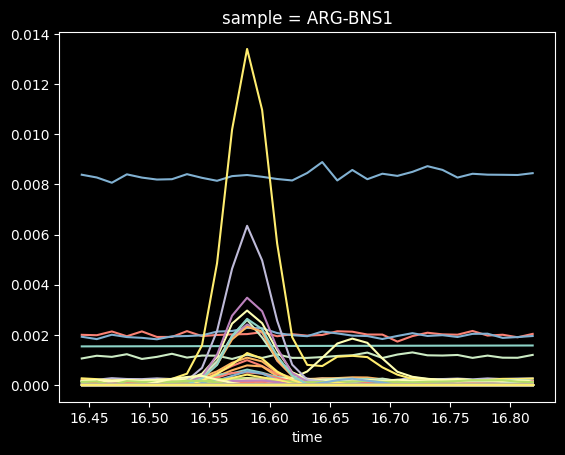

In [8]:
%load_ext autoreload
%autoreload 2

from tensorly.decomposition import parafac2 as tl_parafac2
import numpy as np
import polars as pl
import xarray as xr
import matplotlib.pyplot as plt
from pca_analysis.notebooks.code.zhang_gcms_toy_data import get_zhang_data
from pca_analysis.notebooks.code.parafac2 import Parafac2

raw_data = get_zhang_data()

_decomp, err = tl_parafac2(
    raw_data.to_numpy(),
    3,
    return_errors=True,
    verbose=True,
    n_iter_max=500,
    nn_modes="all",
)
parafac2 = Parafac2(_decomp, raw_data)


# Individual Factors

## B

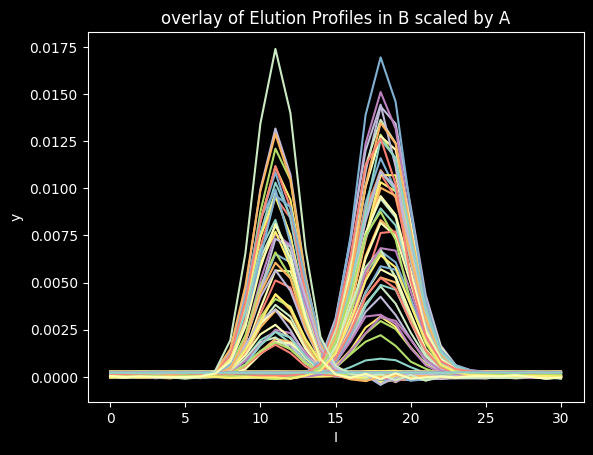

In [9]:
def demonstration_B_scaled(A, B, C):
    B_scaled = [B[k] * a * C[39] for k, a in enumerate(A)]

    for i, k in enumerate(B_scaled):
        plt.plot(k)

    plt.xlabel("I")
    plt.ylabel("y")
    plt.title("overlay of Elution Profiles in B scaled by A")


demonstration_B_scaled(parafac2.pure.B, parafac2.pure.A, parafac2.pure.C)


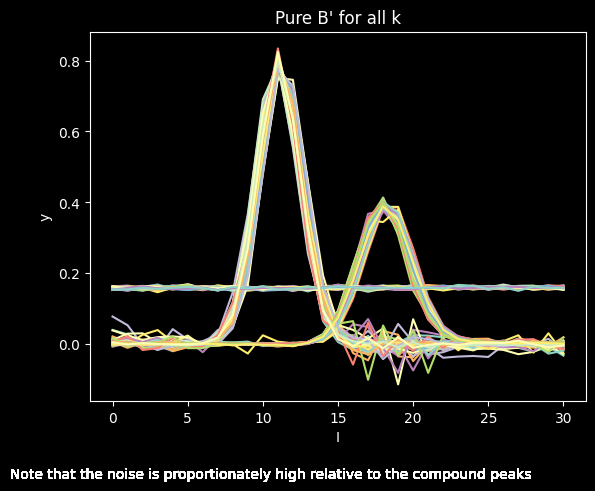

In [10]:
def display_pure_elutions(B_list):
    for i, k in enumerate(B_list):
        plt.plot(k, label=i)
        plt.title("Pure B' for all k")
        plt.xlabel("I")
        plt.ylabel("y")
        plt.figtext(
            0,
            -0.05,
            "Note that the noise is proportionately high relative to the compound peaks",
        )


display_pure_elutions(parafac2.pure.B)


## A

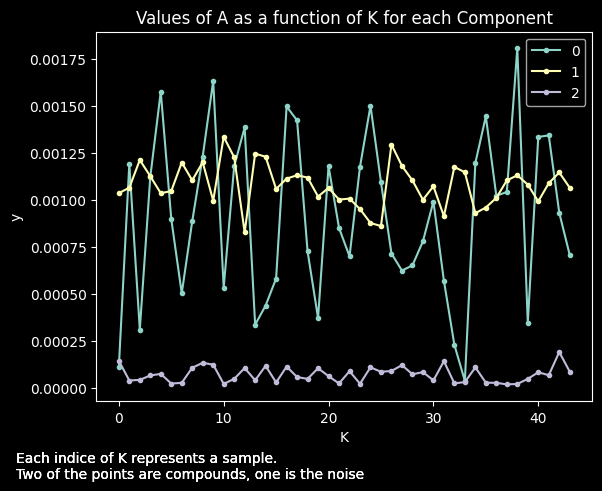

In [11]:
def demonstrate_A_over_K(A):
    for i, r in enumerate(A.T):
        plt.plot(r, ".-", label=i)
        plt.xlabel("K")
        plt.ylabel("y")
        plt.title("Values of A as a function of K for each Component")
        plt.figtext(
            0,
            -0.05,
            "Each indice of K represents a sample.\nTwo of the points are compounds, one is the noise",
        )
        plt.legend()


demonstrate_A_over_K(parafac2.pure.A)


## C

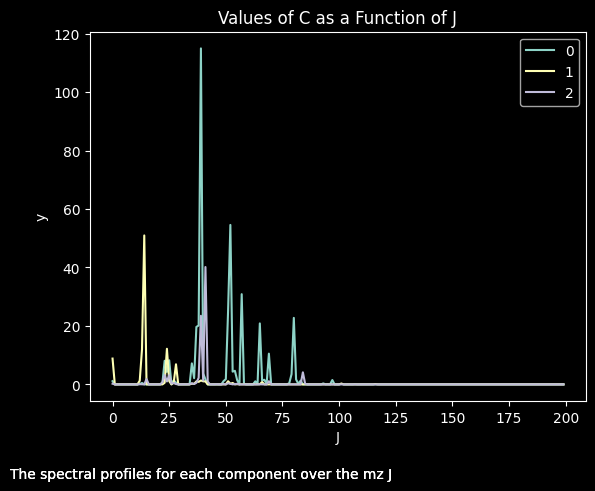

In [12]:
def demonstrate_C_as_func_of_J(C):
    for i, r in enumerate(np.flip(C.T, axis=0)):
        plt.plot(r, label=i)
        plt.xlabel("J")
        plt.ylabel("y")
        plt.legend()
        plt.title("Values of C as a Function of J")
        plt.figtext(0, -0.05, "The spectral profiles for each component over the mz J")


demonstrate_C_as_func_of_J(parafac2.pure.C)


# Reconstruction

(31, 3)
(3,)
(31, 3)
(3,)


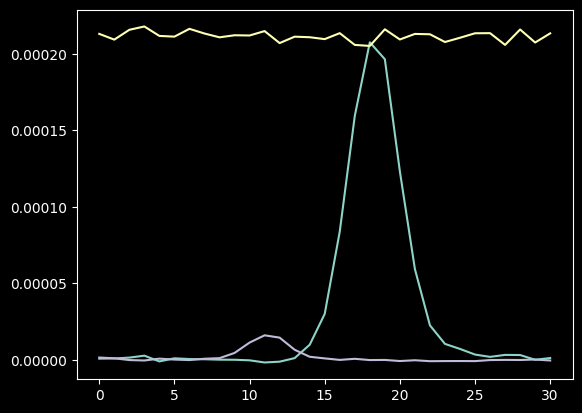

In [13]:
k = 10
j = 39

a = parafac2.pure.A[k]
b = parafac2.pure.B[k]
c = parafac2.pure.C[j]

scaled_b_asterisk = b * a * c

ba = np.multiply(a, b)
print(b.shape)
print(a.shape)
print(ba.shape)
print(c.shape)
plt.plot(ba)
# np.dot(ba,c.T)


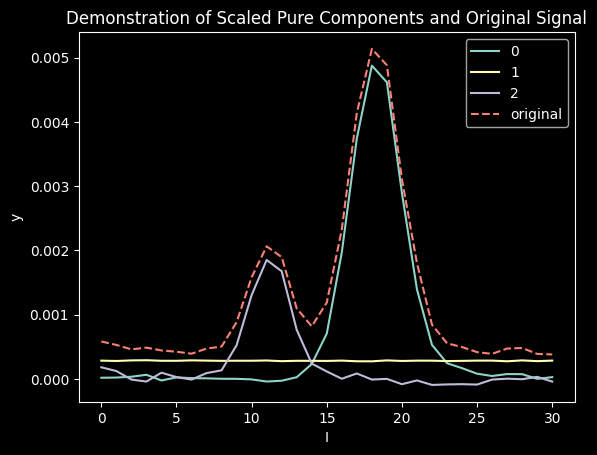

In [14]:
def display_reconstruction(A, B, C, raw_data, k=10, j=39):
    a = A[k]
    b = B[k]
    c = C[j]

    # * performs np.multiply on the args
    scaled_b = b * a * c

    plt.plot(scaled_b, label=list(range(0, b.shape[1])))
    plt.plot(raw_data.isel(sample=k, mz=j), "--", label="original")
    plt.xlabel("I")
    plt.ylabel("y")
    plt.title("Demonstration of Scaled Pure Components and Original Signal")
    plt.legend()


display_reconstruction(
    A=parafac2.pure.A,
    B=parafac2.pure.B,
    C=parafac2.pure.C,
    raw_data=raw_data,
)


As we can see in the above viz, the decomposition looks sound, and fruthermore the visualisation is very informative, containing information about the pure analytes and noise compared to the convoluted signal.


# Conclusion

Using the Zhang et al. GC-MS peak data, observation of the following features was made: The scaled elution profiles, the pure elution profiles, A as a function of K for each component and C as a function of J. A reconstruction routine was developed and visualisations the results of reconstruction. The reconstruction routine/viz should be integrated into a pipeline.